In [ ]:
zip_adres = "/content/drive/My Drive/Keras/PetImages.zip"
!cp "{zip_adres}" . #Google Drive'dan dosyamızı çekip Colab erişimine sunuyoruz

In [ ]:
!unzip -q PetImages.zip #Dosyayı zipten çıkarmaya yarıyor
!rm PetImages.zip #Zip'i açtıktan sonra zip dosyasını siliyor

In [ ]:
# Bu dosyalar Colab'ın diskinde duruyor. Fakat bizim bunları ram'e taşımamız yani colaba yüklememiz lazım.
# Bu dosyaları yüklerken bir şekilde kategorilerini de tutmamız gerekiyor. 
# Yani bizim hem görsellere ihtiyacımız var, hem de onları kategorilemeye ihtiyacımız var.

In [ ]:
import os
import cv2 # OpenCV
from tqdm import tqdm # Dosyalar yüklenirken görsellik sunması açısından kullanılıyor

KATEGORILER = ["Cat", "Dog"]
DIR = "PetImages"

# Biz burada CNN yapacağız. CNN: Resim dosyalarında bir filtre gezdirerek oradan bazı ilişkileri çıkartma metodu.
# CNN çalışırken kare olan (boyutları aynı) görsellerle çalışıyor.
# O yüzden elimizde ki görselleri tek bir boyuta indirgememiz gerekiyor.
BOYUT = 128

veri = []

# Dosyaları tek tek okuyoruz
for kategori in KATEGORILER:
  klasor_adresi = os.path.join(DIR,kategori) # os'in dosya birleştirmesini kullanıyoruz. DIR klasörü ile kategoriyi birleştir diyoruz
  deger = KATEGORILER.index(kategori) # 0 -> Kedi, 1 -> Köpek şeklinde sınıflandırıyoruz.
  for resim_adi in tqdm(os.listdir(klasor_adresi)):
    resim_adresi = os.path.join(klasor_adresi, resim_adi)
    resim = cv2.imread(resim_adresi, cv2.IMREAD_GRAYSCALE) # Resimleri okur ve siyah - beyaz yapma
    if(resim is None):
      print("Hata")
    else:
      resim = cv2.resize(resim, (BOYUT, BOYUT)) # Resmi boyutlandırma
      veri.append([resim, deger]) # Resmi ve resmin değerini (0, 1) veriye ekliyoruz

 34%|███▍      | 345/1000 [00:00<00:00, 836.99it/s]

Hata
Hata


 63%|██████▎   | 632/1000 [00:00<00:00, 917.05it/s]

Hata
Hata
Hata


100%|██████████| 1000/1000 [00:01<00:00, 829.48it/s]


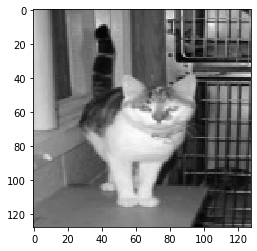

In [ ]:
from matplotlib import pyplot
pyplot.imshow(veri[0][0], cmap="gray")

  Sisteme verdiğimiz verilerin ilk 1000 tanesi kedi, son 1000 tanesi köpek olursa; sistem bu verileri sırasıyla öğrenir. Bu da bizim istemediğimiz bir durum olur.
  Sisteme verileri karıştırarak vermeliyiz.

In [ ]:
import random
random.shuffle(veri) # Veriyi karıştırma işlemi

X = []
Y = []

for x, y in veri: # Veri'nin içerisinde ki görselleri x'e, görsellerin (0,1) bilgilerini y'ye ekliyoruz
  X.append(x)
  Y.append(y) 

del veri # Veri dosyasını ram'de hafıza kaplamaması için siliyoruz. Veri dosyası'nı X ve Y ye atadık.


veri[0][0] -> X[0] ve Y[0] olmuş oluyor.

0


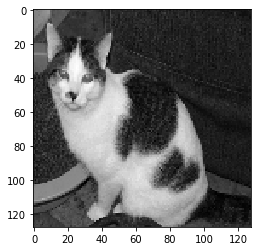

In [ ]:
pyplot.imshow(X[0], cmap="gray") # Veriyi karıştırdığımız için veri[0][0] ile X[0] aynı değil.
print(Y[0]) # Görsel köpek olduğu için bu print çıktısında 1 göreceğiz.

Eğitecek olduğumuz sisteme verileri numpy array şeklinde göndermeliyiz. Numpy Array'e çevirip yeniden boyutlandırma yapıyoruz

In [ ]:
import numpy as np

X = np.array(X).reshape(-1, BOYUT, BOYUT, 1) # Numpy arrayin şekli 64,64,1 olacak. 1 olmasının sebebi renksiz görsellerle sistemi kuruyor olmamızdır.
Y = np.array(Y).reshape(-1, 1)

In [ ]:
X

Bizim verimiz 0-255 arasında değerler içeriyor. Fakat sistemin daha iyi çalışabilmesi için Veriyi bu noktada normalize etmek isteyebiliriz.

In [ ]:
X = X / 255.0

In [ ]:
X

CNN sistemini oluşturmaya başlayabiliriz

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Flatten, Dense

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = X[0].shape, activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
model.add(BatchNormalization()) # Normalization
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = X[0].shape, activation = 'relu'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
model.add(BatchNormalization()) # Normalization
model.add(Flatten()) # Giriş verilerini son katmana hazırlıyor. Verileri tek boyuta düşürüyor.
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) # Relu negatif değerlerde çalışmadığı için sigmoid kullandık. Bu aşamada aslında sistemin tek bir çıktı üretmesini istiyoruz. Ya 0, Ya da 1

model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate=0.0000001), metrics = ['acc'])

mc = ModelCheckpoint('en_iyi.h5', save_best_only = True, monitor = 'val_loss', mode = 'min') # val_acc'ler yükseldikçe modeli kaydetmek isteyebiliriz. Veya ara sıra model kaydedilsin isteyebiliriz.

model.fit(x = X, y = Y, batch_size = 32, epochs = 100, shuffle = True, validation_split = 0.2, callbacks = [mc])

Train on 1596 samples, validate on 399 samples
Epoch 1/100
1596/1596 [==============================] - 8s 5ms/sample - loss: 0.7126 - acc: 0.5188 - val_loss: 0.6925 - val_acc: 0.5188
Epoch 2/100
1596/1596 [==============================] - 6s 4ms/sample - loss: 0.7034 - acc: 0.5345 - val_loss: 0.6919 - val_acc: 0.5213
Epoch 3/100
1596/1596 [==============================] - 6s 4ms/sample - loss: 0.6947 - acc: 0.5464 - val_loss: 0.6914 - val_acc: 0.5213
Epoch 4/100
1596/1596 [==============================] - 6s 4ms/sample - loss: 0.6876 - acc: 0.5589 - val_loss: 0.6907 - val_acc: 0.5163
Epoch 5/100
1596/1596 [==============================] - 6s 4ms/sample - loss: 0.6771 - acc: 0.5821 - val_loss: 0.6894 - val_acc: 0.5313
Epoch 6/100
1596/1596 [==============================] - 6s 4ms/sample - loss: 0.6706 - acc: 0.5846 - val_loss: 0.6875 - val_acc: 0.5388
Epoch 7/100
1596/1596 [==============================] - 6s 4ms/sample - loss: 0.6646 - acc: 0.5934 - val_loss: 0.6851 - val_acc: 0

KeyboardInterrupt: ignored

0.5989975


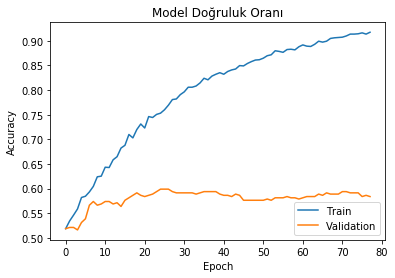

In [ ]:
pyplot.plot(model.history.history['acc'])
pyplot.plot(model.history.history['val_acc'])
pyplot.title('Model Doğruluk Oranı')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc = 'lower right')
pyplot.savefig('sema.png', dpi = 300)
print(max(model.history.history['val_acc']))

Modeli kaydetmek

In [ ]:
model.save('model.h5')

Modeli yüklemek

In [ ]:
from tensorflow.keras.models import load_model
yuklenen_model = load_model('model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
yuklenen_model.summary() # Yüklenen modelin özeti

2.24.06